In [1]:
import numpy as np
import pandas as pd
import scanpy as sc 

adata = sc.read_h5ad("dataset_co_mo.h5ad")
#lr_genes = pd.read_csv("dataset_co_mo.csv", header=0)  # Or header=True if you're on an older pandas version

In [2]:
# Extract source and receiver genes efficiently
gl_source = ['TGFBR2', 'SMAD3', 'HIF1A', 'PDGFB'] # All values from the first column
gl_recv =['TGFB1', 'IL6', 'PDGFRB']  # All values from the second column

ict1 = adata.obs["BatchID"] == "Cancer Cells (Mo)"
ict2 = adata.obs["BatchID"] == "Fibroblasts (Mo)" 
adata_ct1 = adata[ict1, gl_source]
adata_ct2 = adata[ict2, gl_recv]
print(adata_ct1)
print(adata_ct2)

Xct1 = adata_ct1.X.copy()
Xct2 = adata_ct2.X.copy()
Xct1 = Xct1.toarray()
Xct2 = Xct2.toarray()
# Compute cell percentace of cell type 1 count matrix
Xct1p = np.sum(Xct1>0, axis=0)/len(Xct1[:,0])
Xct2p = np.sum(Xct2>0, axis=0)/len(Xct2[:,0])

print("CT1 Percentages:", Xct1p)
print("CT2 Percentages:", Xct2p)

# Scale the data from 0 to 1 to -pi/2 to pi/2 | 2*pi or pi?
ct1_percentages = (Xct1p-0.5) * np.pi*2*0.9
ct2_percentages = (Xct2p-0.5) * np.pi*2*0.9
#ct1_percentages = (Xct1p-0.5) * np.pi
#ct2_percentages = (Xct2p-0.5) * np.pi
# Display the resulting scaled data
print("Scaled ct1_data:\n", ct1_percentages)
print("Scaled ct2_data:\n", ct2_percentages)

View of AnnData object with n_obs × n_vars = 2364 × 4
    obs: 'CellID', 'BatchID', 'ClusterID', 'CellType', 'CellCycle'
View of AnnData object with n_obs × n_vars = 2788 × 3
    obs: 'CellID', 'BatchID', 'ClusterID', 'CellType', 'CellCycle'
CT1 Percentages: [0.36759729 0.8071066  0.89932318 0.09898477]
CT2 Percentages: [0.42969871 0.42898135 0.29196557]
Scaled ct1_data:
 [-0.74871967  1.7366469   2.25811939 -2.26768769]
Scaled ct2_data:
 [-0.39754444 -0.40160101 -1.17640701]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def create_joint_histogram(Xct1bool):
    """
    Creates a joint histogram of boolean columns from a NumPy array.
    """
    num_cols = Xct1bool.shape[1]
    joint_counts = Counter()
    bit_strings = set()

    for row in Xct1bool:
        bit_string = "".join(["1" if val else "0" for val in row])
        joint_counts[bit_string] += 1
        bit_strings.add(bit_string)

    return joint_counts, sorted(list(bit_strings))


def plot_joint_histogram(joint_counts, num_qubits, reverse_bits=False):
    """Plots the joint histogram, accounting for potential bit reversal."""
    
    all_bit_strings = [''.join(format(i, f'0{num_qubits}b')) for i in range(2**num_qubits)]
    
    counts = []
    mapped_bit_strings = []

    for bit_string in all_bit_strings:
        if reverse_bits:
            reversed_string = bit_string[::-1]  # Reverse bit order
            count_value = joint_counts.get(bit_string, 0)  # Extract count from original order
            mapped_bit_strings.append(reversed_string)  # Assign to reversed bit string
        else:
            count_value = joint_counts.get(bit_string, 0)
            mapped_bit_strings.append(bit_string)  # Keep regular order

        counts.append(count_value)

    # Sort bit strings by Hamming weight (count of '1's), then numerically
    sorted_pairs = sorted(zip(mapped_bit_strings, counts), key=lambda x: int(x[0], 2))

    # Unzip the sorted pairs
    sorted_bit_strings, sorted_counts = zip(*sorted_pairs)

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_bit_strings, sorted_counts)

    plt.xlabel(f"Bit String (q{num_qubits-1} ... q0)")
    plt.ylabel("Frequency")
    plt.title("Joint Histogram of Boolean Columns")
    plt.xticks(rotation=45, ha="right")

    for i, count in enumerate(counts):
        plt.text(mapped_bit_strings[i], count, str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

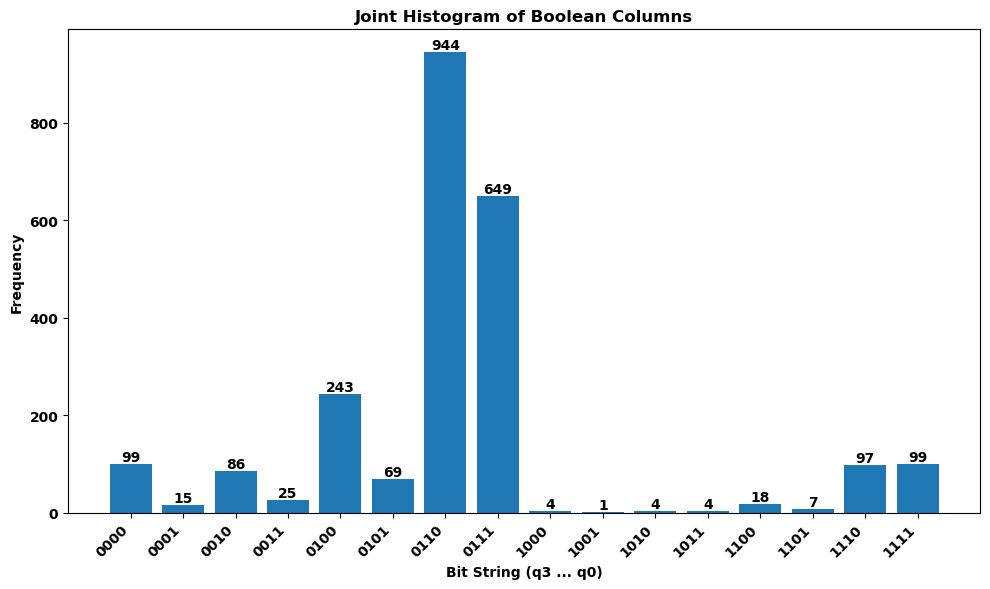

Joint Counts: Counter({'0110': 944, '1110': 649, '0010': 243, '0000': 99, '1111': 99, '0111': 97, '0100': 86, '1010': 69, '1100': 25, '0011': 18, '1000': 15, '1011': 7, '0101': 4, '1101': 4, '0001': 4, '1001': 1})
Bit Strings: ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


In [5]:
# Example Usage (assuming Xct1 is defined):
Xct1bool = Xct1 > 0  # Create boolean array

joint_counts, bit_strings = create_joint_histogram(Xct1bool)

num_qubits = Xct1bool.shape[1]  # Get the number of qubits (important!)
plot_joint_histogram(joint_counts, num_qubits, reverse_bits=True)  # Pass num_qubits

print("Joint Counts:", joint_counts)
print("Bit Strings:", bit_strings)

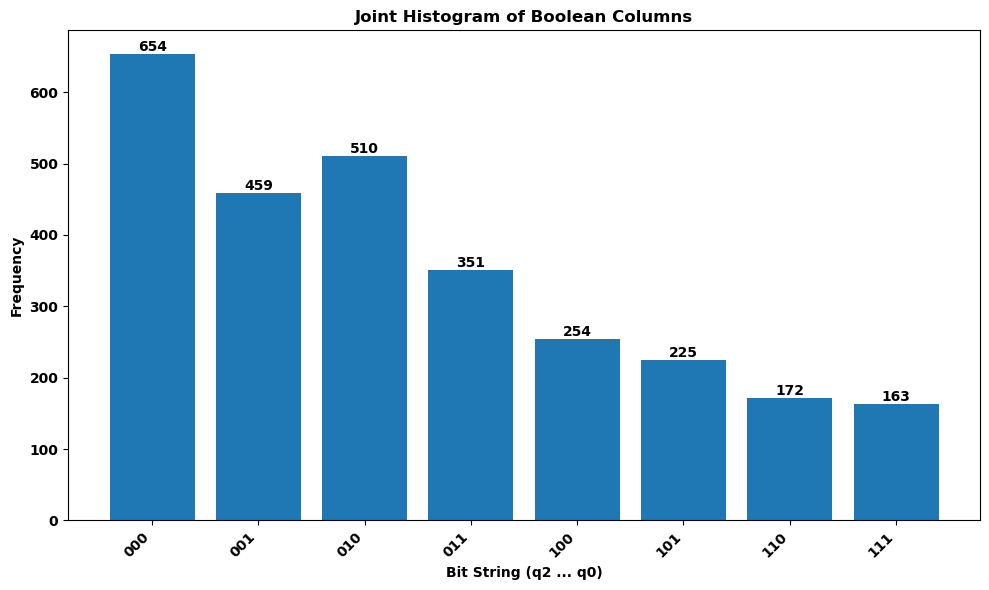

Joint Counts: Counter({'000': 654, '010': 510, '100': 459, '110': 351, '001': 254, '101': 225, '011': 172, '111': 163})
Bit Strings: ['000', '001', '010', '011', '100', '101', '110', '111']


In [6]:
# Example Usage (assuming Xct1 is defined):
Xct2bool = Xct2 > 0  # Create boolean array

joint_counts2, bit_strings2 = create_joint_histogram(Xct2bool)

num_qubits2 = Xct2bool.shape[1]  # Get the number of qubits (important!)
plot_joint_histogram(joint_counts2, num_qubits2, reverse_bits=True)  # Pass num_qubits

print("Joint Counts:", joint_counts2)
print("Bit Strings:", bit_strings2)

In [ ]:
import matplotlib.pyplot as plt
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
import numpy as np

def create_grn_ansatz(ng, cell_type):
    """
    Creates a parameterized quantum circuit representing a Gene Regulatory Network (GRN) ansatz.

    Args:
        ng: The number of genes in the network.
        cell_type: A string identifier for the cell type (e.g., "CT1", "CT2").

    Returns:
        A QuantumCircuit object representing the GRN ansatz.
    """

    cell_type = cell_type.lower()
    ansatz_grn = QuantumCircuit(ng, name=f"{cell_type}_GRN_Ansatz")

    # Gene activation probabilities (RY rotations after Hadamard)
    params_act = [Parameter(f'{cell_type}_act_{i}') for i in range(ng)]
    for i in range(ng):
        ansatz_grn.h(i)
        ansatz_grn.rz(params_act[i], i)  # Use RZ for activation

    # Gene interaction CRX gates
    for i in range(ng):
        for j in range(ng):
            if i != j:
                param_name = f'{cell_type}_grn_{i}_{j}'
                param = Parameter(param_name)
                ansatz_grn.crx(param, i, j)

    return ansatz_grn

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from qiskit.quantum_info import SparsePauliOp

def create_interaction_observable_from_histogram(joint_counts, num_features, min_ones=2, standardize=False):
    """Creates a SparsePauliOp from joint histogram counts, 
       considering interactions with a minimum number of '1's.
    Args:
        joint_counts: A Counter object from create_joint_histogram.
        num_features: The total number of qubits.
        min_ones: The minimum number of '1's required in a bit string 
                  for the interaction to be included.
        standardize: If True, standardizes the counts before calculating strengths.
    Returns:
        A SparsePauliOp observable.
    """
    interaction_strength_list = []

    # Prepare counts for standardization if needed
    counts_array = np.array(list(joint_counts.values()))
    if standardize:
        mean_count = np.mean(counts_array)
        std_count = np.std(counts_array)
        if std_count == 0:  # Handle case where all counts are the same
            standardized_counts = np.zeros_like(counts_array)
        else:
            standardized_counts = (counts_array - mean_count) / std_count
        
        # Create a dictionary to map bitstrings to standardized counts
        bitstring_to_std_count = dict(zip(joint_counts.keys(), standardized_counts))

    for bit_string, count in joint_counts.items():
        num_ones = bit_string.count('1')  # Count the number of '1's

        if num_ones >= min_ones:  # Consider only if at least min_ones '1's are present
            nodes = tuple(i for i, bit in enumerate(bit_string) if bit == '1')
            
            if standardize:
                strength = -bitstring_to_std_count[bit_string]  # Use standardized count
            else:
                strength = -count  # Use original count

            pauli_string = ""
            for i in range(num_features):
                if i in nodes:
                    pauli_string += "Z"
                else:
                    pauli_string += "I"
            interaction_strength_list.append((pauli_string, strength))

    interaction_observable = SparsePauliOp.from_list(interaction_strength_list)
    return interaction_observable


import matplotlib.pyplot as plt
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
#from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler  # If using IBM Runtime
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.visualization import plot_histogram

def evaluate_and_plot_ansatz(ansatz, params, shots=1024, title="Quantum Sampler Results"):
    """Evaluates a quantum ansatz, plots results and circuit, and prints counts."""

    try:
        sampler = StatevectorSampler()
        bound_circuit = ansatz.copy()
        bound_circuit.assign_parameters(params, inplace=True)
        bound_circuit.measure_all()

        job = sampler.run([bound_circuit], shots=shots)
        pub_result = job.result()[0]
        data_pub = pub_result.data
        counts = data_pub.meas.get_counts()

        print(f"The counts are: {counts}")

        # Plot histogram:
        plot_histogram(counts, title=title).show()

        # Matplotlib customization:
        sorted_counts = dict(sorted(counts.items()))
        x_labels = list(sorted_counts.keys())
        y_values = list(sorted_counts.values())

        plt.figure(figsize=(10, 6))
        plt.bar(x_labels, y_values)
        plt.xlabel("Measurement Outcomes")
        plt.ylabel("Counts")
        plt.title(title)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        return counts, bound_circuit

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


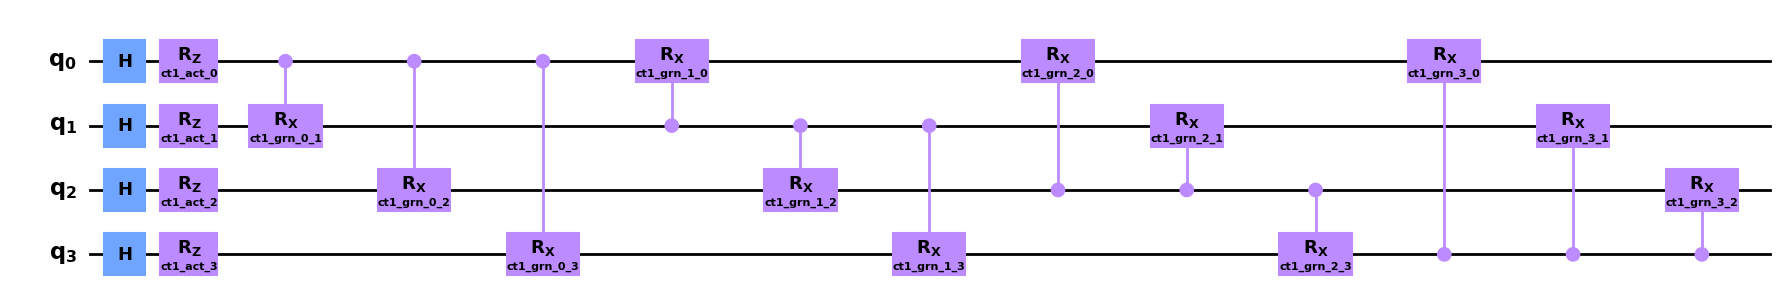

In [8]:
ng_ct1 = len(gl_source)  # Assuming gl_source is defined elsewhere
ansatz_grn_ct1_mo = create_grn_ansatz(ng_ct1, "CT1")
ansatz_grn_ct1_mo.draw(output="mpl", style="clifford", fold=40)

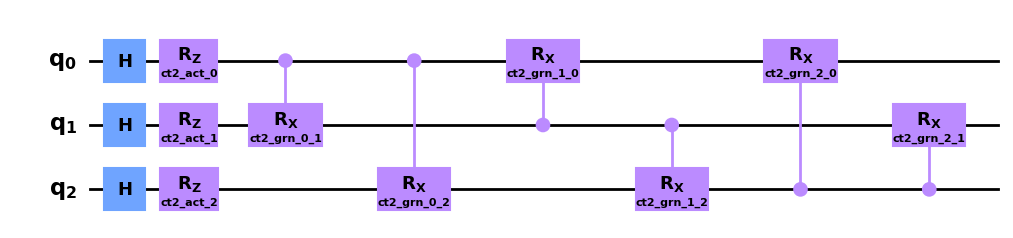

In [9]:
ng_ct2 = len(gl_recv)  #Example for a second cell type
ansatz_grn_ct2_mo = create_grn_ansatz(ng_ct2, "CT2")
ansatz_grn_ct2_mo.draw(output="mpl", style="clifford", fold=40)

In [ ]:
# --- Create the FULL parameter dictionary BEFORE optimization ---
def create_parameter_dictionaries(combined_qc, ct1_percentages):
    """Creates static and variable parameter dictionaries."""
    # Get Hadamard parameters
    params_ct = [param for param in combined_qc.parameters if 'ct1_' in param.name or 'ct2_' in param.name
                                                            and 'grn' not in param.name 
                                                            and 'lr' not in param.name ]
    static_params = {}
    for i, val in enumerate(ct1_percentages):
        static_params[params_ct[i]] = val

    variable_params = [param for param in combined_qc.parameters if param not in static_params]
    return static_params, variable_params

from qiskit.quantum_info import Statevector

def cost_func_vqe(params, combined_qc, hamiltonian, estimator):  # combined_qc here
    """Cost function for VQE"""
    bound_qc = combined_qc.assign_parameters(params)  # Assign parameters INSIDE cost_func_vqe
    statevector = Statevector(bound_qc)  # Use bound_qc
    statevector_array = statevector.data
    hamiltonian_matrix = hamiltonian.to_matrix()
    energy = np.real(statevector_array.conjugate() @ hamiltonian_matrix @ statevector_array)
    return energy

def cost_func_wrapper(variable_values, all_params, combined_qc, interaction_observable, estimator, variable_params):
    for i, param in enumerate(variable_params):
        all_params[param] = variable_values[i]
    return cost_func_vqe(all_params, combined_qc, interaction_observable, estimator) # Pass combined_qc


Interaction observable CT1 from histogram: SparsePauliOp(['IZZI', 'ZZZZ', 'ZZZI', 'IZZZ', 'ZIZI', 'ZZII', 'IIZZ', 'IZIZ', 'ZZIZ', 'ZIIZ', 'ZIZZ'],
              coeffs=[-944.+0.j,  -99.+0.j, -649.+0.j,  -97.+0.j,  -69.+0.j,  -25.+0.j,
  -18.+0.j,   -4.+0.j,   -4.+0.j,   -1.+0.j,   -7.+0.j])
Static Parameters: {Parameter(ct1_act_0): -0.7487196704875166, Parameter(ct1_act_1): 1.736646903431109, Parameter(ct1_act_2): 2.258119389585354, Parameter(ct1_act_3): -2.2676876920835967}
Variable Parameters: [Parameter(ct1_grn_0_1), Parameter(ct1_grn_0_2), Parameter(ct1_grn_0_3), Parameter(ct1_grn_1_0), Parameter(ct1_grn_1_2), Parameter(ct1_grn_1_3), Parameter(ct1_grn_2_0), Parameter(ct1_grn_2_1), Parameter(ct1_grn_2_3), Parameter(ct1_grn_3_0), Parameter(ct1_grn_3_1), Parameter(ct1_grn_3_2)]
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -1267.2832419686918
        x: [ 1.407e+00 -1.946e+00 -3.800e-01  1.818e+00 -1.209e+00
             5.705e

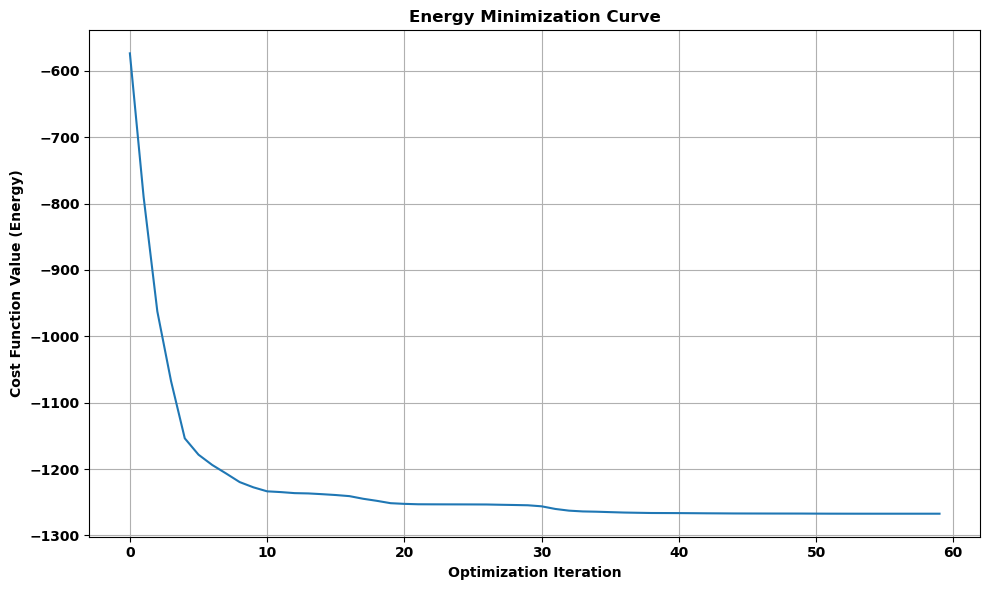

In [13]:
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

num_features = Xct1bool.shape[1]  # Get the number of features dynamically

interaction_observable = create_interaction_observable_from_histogram(joint_counts, num_features, min_ones = 2, standardize=False)
print("Interaction observable CT1 from histogram:", interaction_observable)

static_params, variable_params = create_parameter_dictionaries(ansatz_grn_ct1_mo, ct1_percentages)

print("Static Parameters:", static_params)
print("Variable Parameters:", variable_params)

estimator = StatevectorEstimator()

# Initialize variable parameters
x0_interaction = np.zeros(len(variable_params))  # All zeros

# Create initial full parameter dictionary - THIS IS THE KEY CHANGE
all_params = static_params.copy()  # Start with static parameters
all_params.update(dict(zip(variable_params, x0_interaction)))  # Add variable parameters

cost_values = []
# Call minimize with args
result_interaction_bfgs = minimize(
    cost_func_wrapper,
    x0_interaction,
    args=(all_params, ansatz_grn_ct1_mo, interaction_observable, estimator, variable_params), # Pass all the arguments as a tuple
    method="L-BFGS-B",
    callback=lambda xk: cost_values.append(cost_func_wrapper(xk, all_params, ansatz_grn_ct1_mo, interaction_observable, estimator, variable_params))
)

print(result_interaction_bfgs)

# --- 6. Results and DataFrame ---
optimized_variable_parameters = result_interaction_bfgs.x

# Update the full parameter dictionary with optimized variable parameters
for param, value in zip(variable_params, optimized_variable_parameters):
    all_params[param] = value

import matplotlib.pyplot as plt

# Plot the cost function values
plt.figure(figsize=(10, 6))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

The counts are: {'0000': 64, '0110': 656, '1111': 106, '0011': 18, '1000': 53, '0001': 38, '0111': 16, '1100': 2, '1010': 12, '1110': 9, '0100': 16, '1001': 32, '0010': 1, '1101': 1}


C:\Users\ssromerogon\AppData\Local\Temp\ipykernel_35344\3780699962.py:148: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts, title=title).show()


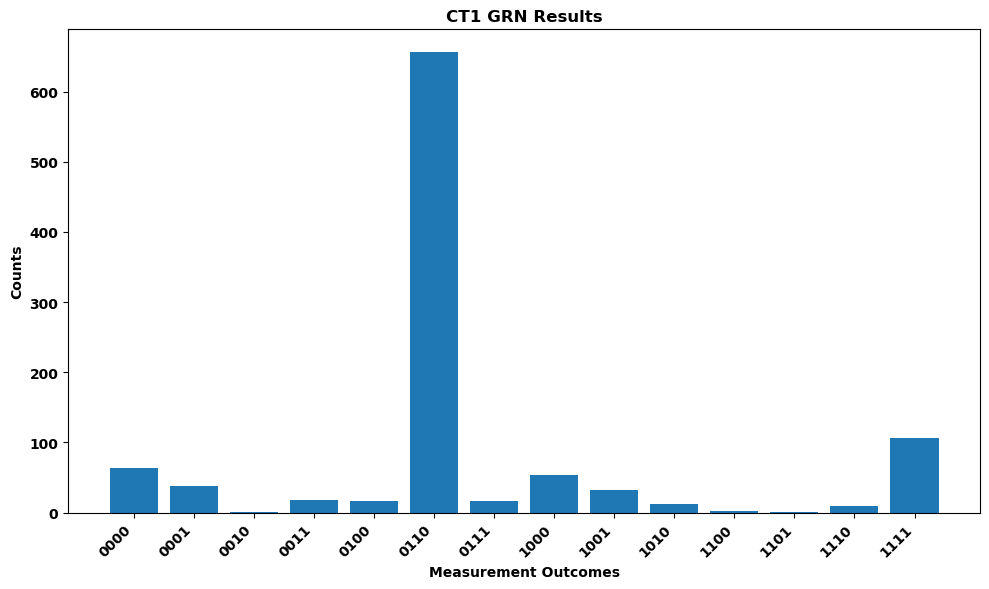

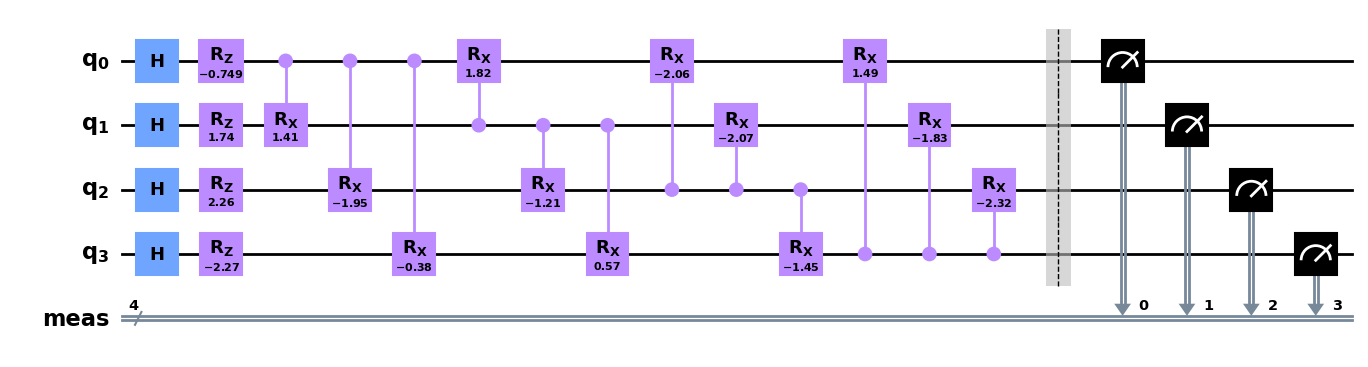

In [14]:
counts_ct1, bound_circuit = evaluate_and_plot_ansatz(ansatz_grn_ct1_mo, all_params, title="CT1 GRN Results")

bound_circuit.draw(output="mpl", style="clifford", fold=40)  # Show the circuit plot

Interaction observable CT2 from histogram: SparsePauliOp(['ZIZ', 'IZI', 'ZII', 'IZZ', 'ZZI', 'ZZZ', 'IIZ'],
              coeffs=[-225.+0.j, -510.+0.j, -459.+0.j, -172.+0.j, -351.+0.j, -163.+0.j,
 -254.+0.j])
Static Parameters: {Parameter(ct2_act_0): -0.39754443622183616, Parameter(ct2_act_1): -0.4016010121016509, Parameter(ct2_act_2): -1.1764070051462494}
Variable Parameters: [Parameter(ct2_grn_0_1), Parameter(ct2_grn_0_2), Parameter(ct2_grn_1_0), Parameter(ct2_grn_1_2), Parameter(ct2_grn_2_0), Parameter(ct2_grn_2_1)]
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -286.63470583526976
        x: [-1.693e+00 -1.556e+00  9.338e-01 -2.236e+00  9.659e-01
             1.625e+00]
      nit: 19
      jac: [-6.821e-05  7.390e-05 -1.137e-05 -5.684e-06  0.000e+00
            -2.274e-05]
     nfev: 147
     njev: 21
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


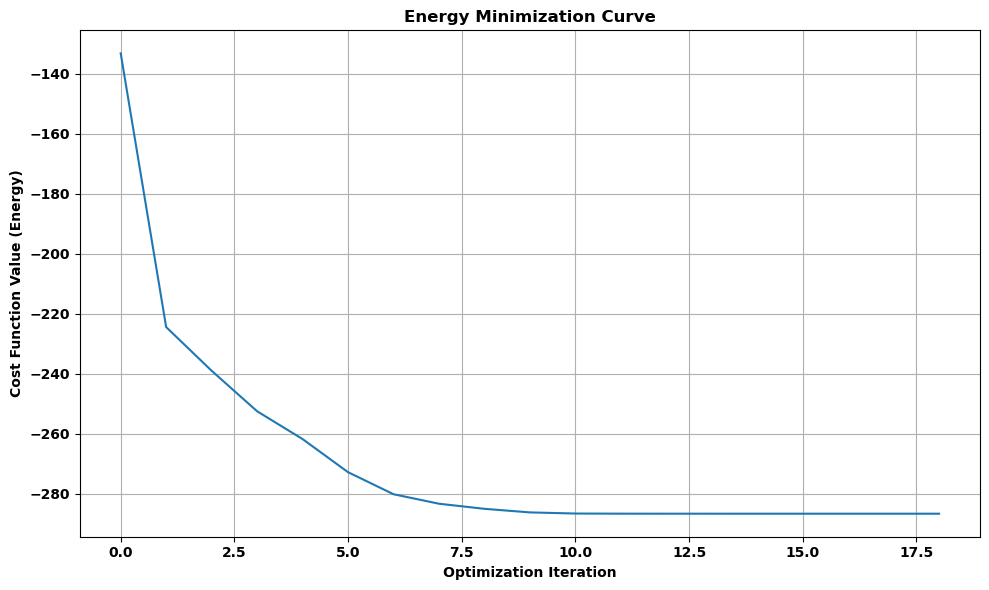

In [15]:
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

num_features2 = Xct2bool.shape[1]  # Get the number of features dynamically

interaction_observable2 = create_interaction_observable_from_histogram(joint_counts2, num_features2, min_ones = 1, standardize=False)
print("Interaction observable CT2 from histogram:", interaction_observable2)

static_params2, variable_params2 = create_parameter_dictionaries(ansatz_grn_ct2_mo, ct2_percentages)

print("Static Parameters:", static_params2)
print("Variable Parameters:", variable_params2)

estimator = StatevectorEstimator()
# Initialize variable parameters
x0_interaction = np.zeros(len(variable_params2))  # All zeros

# Create initial full parameter dictionary - THIS IS THE KEY CHANGE
all_params2 = static_params2.copy()  # Start with static parameters
all_params2.update(dict(zip(variable_params2, x0_interaction)))  # Add variable parameters

cost_values = []
# Call minimize with args, using a lambda for the callback
result_interaction_bfgs = minimize(
    cost_func_wrapper,
    x0_interaction,
    args=(all_params2, ansatz_grn_ct2_mo, interaction_observable2, estimator, variable_params2),
    method="L-BFGS-B",
    callback=lambda xk: cost_values.append(cost_func_wrapper(xk, all_params2, ansatz_grn_ct2_mo, interaction_observable2, estimator, variable_params2))
)

print(result_interaction_bfgs)

# --- 6. Results and DataFrame ---
optimized_variable_parameters = result_interaction_bfgs.x

# Update the full parameter dictionary with optimized variable parameters
for param, value in zip(variable_params2, optimized_variable_parameters):
    all_params2[param] = value

import matplotlib.pyplot as plt

# Plot the cost function values
plt.figure(figsize=(10, 6))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

The counts are: {'001': 358, '010': 240, '100': 272, '011': 4, '000': 132, '101': 3, '111': 14, '110': 1}


C:\Users\ssromerogon\AppData\Local\Temp\ipykernel_35344\3780699962.py:148: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts, title=title).show()


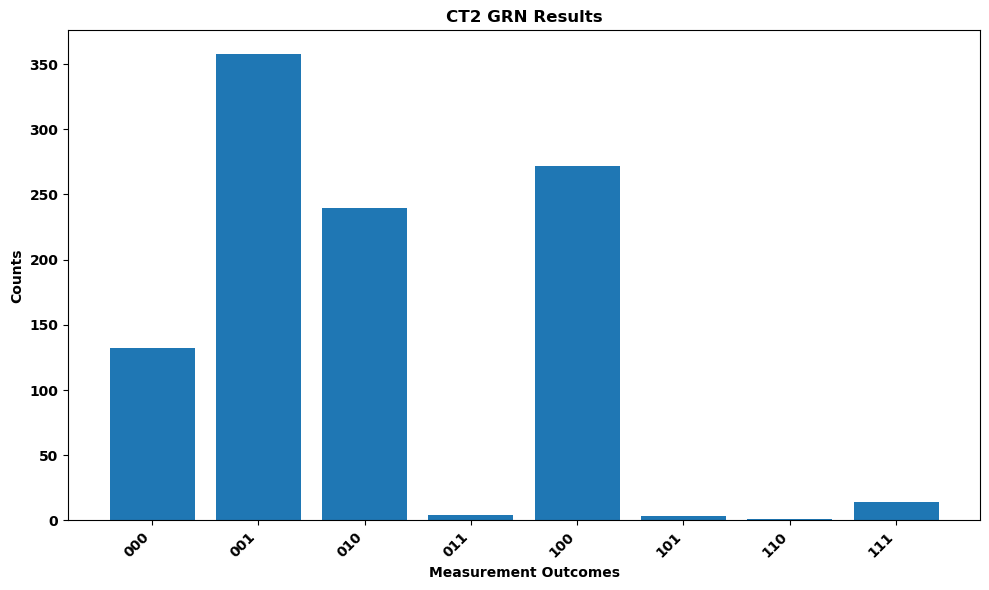

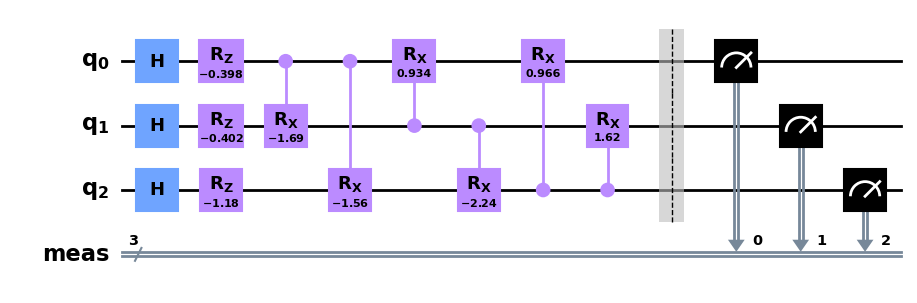

In [16]:
counts_ct2, bound_circuit2 = evaluate_and_plot_ansatz(ansatz_grn_ct2_mo, all_params2, title="CT2 GRN Results")

bound_circuit2.draw(output="mpl", style="clifford", fold=40)  # Show the circuit plot

In [17]:
# Extract source and receiver genes efficiently
gl_source = ['TGFBR2', 'SMAD3', 'HIF1A', 'PDGFB'] # All values from the first column
gl_recv =['TGFB1', 'IL6', 'PDGFRB']  # All values from the second column

ict1 = adata.obs["BatchID"] == "Cancer Cells (Co)"
ict2 = adata.obs["BatchID"] == "Fibroblasts (Co)" 
adata_ct1 = adata[ict1, gl_source]
adata_ct2 = adata[ict2, gl_recv]
print(adata_ct1)
print(adata_ct2)

Xct1 = adata_ct1.X.copy()
Xct2 = adata_ct2.X.copy()
Xct1 = Xct1.toarray()
Xct2 = Xct2.toarray()
# Compute cell percentace of cell type 1 count matrix
Xct1p = np.sum(Xct1>0, axis=0)/len(Xct1[:,0])
Xct2p = np.sum(Xct2>0, axis=0)/len(Xct2[:,0])

print("CT1 Percentages:", Xct1p)
print("CT2 Percentages:", Xct2p)

# Scale the data from 0 to 1 to -pi/2 to pi/2 | 2*pi or pi?
ct1_percentages = (Xct1p-0.5) * np.pi*2*0.9
ct2_percentages = (Xct2p-0.5) * np.pi*2*0.9
#ct1_percentages = (Xct1p-0.5) * np.pi
#ct2_percentages = (Xct2p-0.5) * np.pi
# Display the resulting scaled data
print("Scaled ct1_data:\n", ct1_percentages)
print("Scaled ct2_data:\n", ct2_percentages)

View of AnnData object with n_obs × n_vars = 1414 × 4
    obs: 'CellID', 'BatchID', 'ClusterID', 'CellType', 'CellCycle'
View of AnnData object with n_obs × n_vars = 1324 × 3
    obs: 'CellID', 'BatchID', 'ClusterID', 'CellType', 'CellCycle'
CT1 Percentages: [0.3748232  0.79915134 0.88260255 0.29915134]
CT2 Percentages: [0.51812689 0.18806647 0.41993958]
Scaled ct1_data:
 [-0.70785815  1.69166099  2.16356643 -1.13577239]
Scaled ct2_data:
 [ 0.10250514 -1.76394258 -0.45273103]


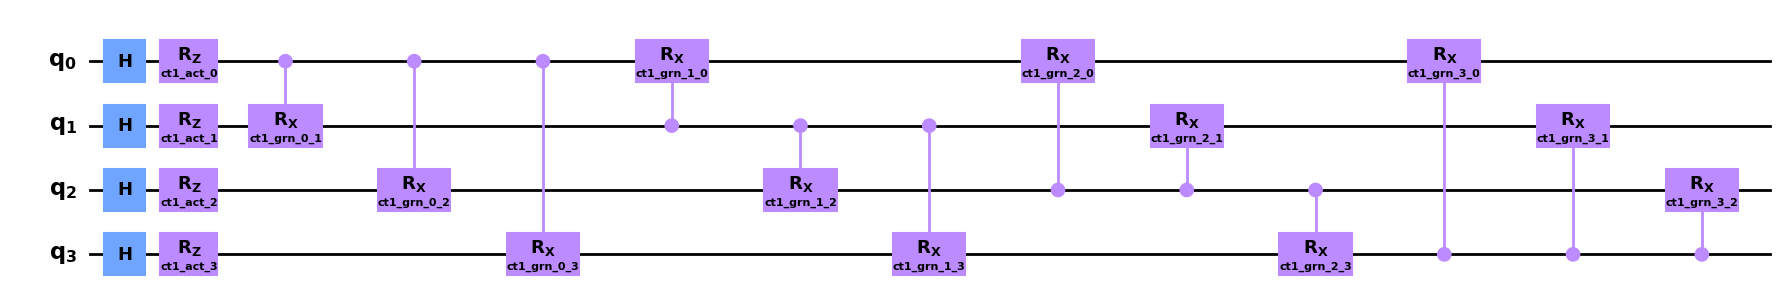

In [18]:
ng_ct1 = len(gl_source)  # Assuming gl_source is defined elsewhere
ansatz_grn_ct1_co = create_grn_ansatz(ng_ct1, "CT1")
ansatz_grn_ct1_co.draw(output="mpl", style="clifford", fold=40)

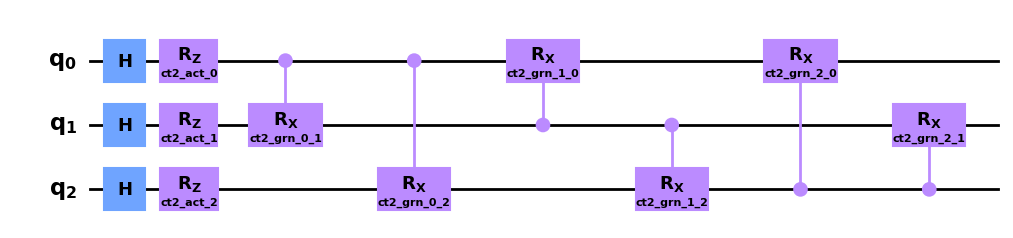

In [19]:
ng_ct2 = len(gl_recv)  #Example for a second cell type
ansatz_grn_ct2_co = create_grn_ansatz(ng_ct2, "CT2")
ansatz_grn_ct2_co.draw(output="mpl", style="clifford", fold=40)

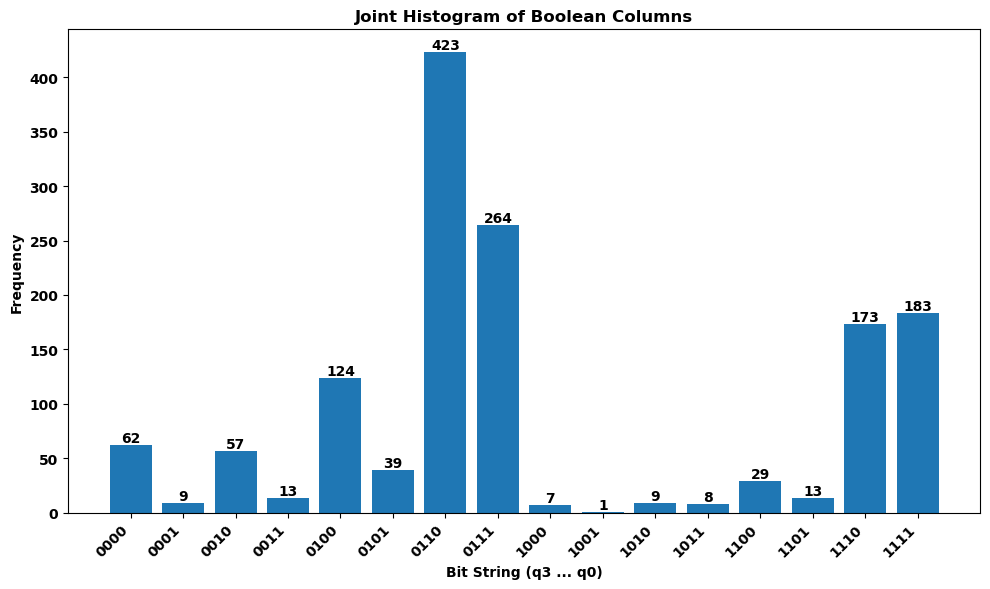

Joint Counts: Counter({'0110': 423, '1110': 264, '1111': 183, '0111': 173, '0010': 124, '0000': 62, '0100': 57, '1010': 39, '0011': 29, '1100': 13, '1011': 13, '1000': 9, '0101': 9, '1101': 8, '0001': 7, '1001': 1})
Bit Strings: ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


In [20]:
# Example Usage (assuming Xct1 is defined):
Xct1bool = Xct1 > 0  # Create boolean array

joint_counts, bit_strings = create_joint_histogram(Xct1bool)

num_qubits = Xct1bool.shape[1]  # Get the number of qubits (important!)
plot_joint_histogram(joint_counts, num_qubits, reverse_bits=True)  # Pass num_qubits

print("Joint Counts:", joint_counts)
print("Bit Strings:", bit_strings)

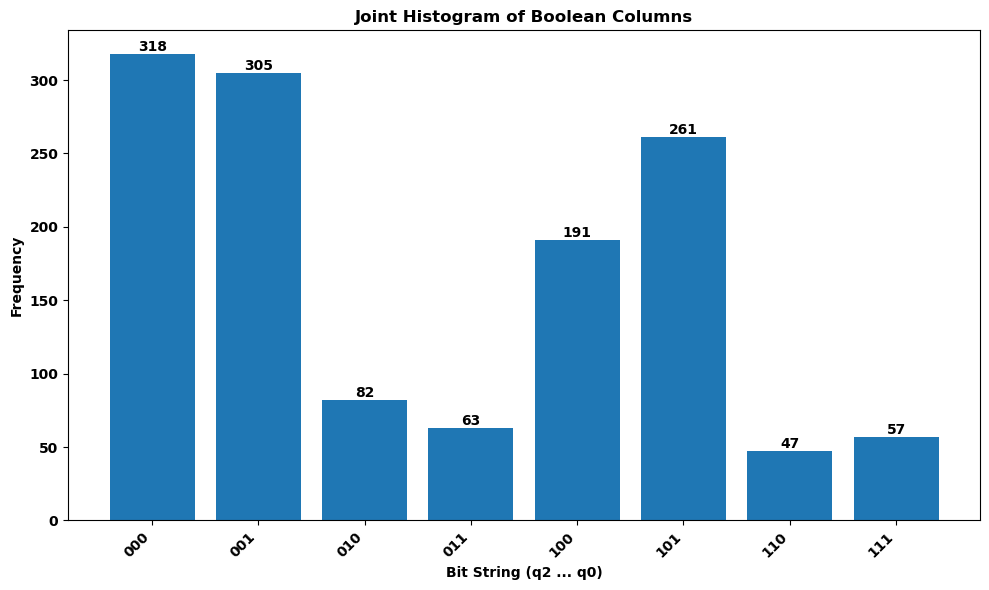

Joint Counts: Counter({'000': 318, '100': 305, '101': 261, '001': 191, '010': 82, '110': 63, '111': 57, '011': 47})
Bit Strings: ['000', '001', '010', '011', '100', '101', '110', '111']


In [21]:
# Example Usage (assuming Xct1 is defined):
Xct2bool = Xct2 > 0  # Create boolean array

joint_counts2, bit_strings2 = create_joint_histogram(Xct2bool)

num_qubits2 = Xct2bool.shape[1]  # Get the number of qubits (important!)
plot_joint_histogram(joint_counts2, num_qubits2, reverse_bits=True)  # Pass num_qubits

print("Joint Counts:", joint_counts2)
print("Bit Strings:", bit_strings2)

Interaction observable CT1 from histogram: SparsePauliOp(['IZZZ', 'ZZZI', 'IIZZ', 'IZZI', 'ZZIZ', 'ZZZZ', 'ZIZI', 'ZZII', 'ZIZZ', 'IZIZ', 'ZIIZ'],
              coeffs=[-173.+0.j, -264.+0.j,  -29.+0.j, -423.+0.j,   -8.+0.j, -183.+0.j,
  -39.+0.j,  -13.+0.j,  -13.+0.j,   -9.+0.j,   -1.+0.j])
Static Parameters: {Parameter(ct1_act_0): -0.707858146699935, Parameter(ct1_act_1): 1.6916609946557766, Parameter(ct1_act_2): 2.1635664257890674, Parameter(ct1_act_3): -1.135772393575037}
Variable Parameters: [Parameter(ct1_grn_0_1), Parameter(ct1_grn_0_2), Parameter(ct1_grn_0_3), Parameter(ct1_grn_1_0), Parameter(ct1_grn_1_2), Parameter(ct1_grn_1_3), Parameter(ct1_grn_2_0), Parameter(ct1_grn_2_1), Parameter(ct1_grn_2_3), Parameter(ct1_grn_3_0), Parameter(ct1_grn_3_1), Parameter(ct1_grn_3_2)]
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -713.0975579143573
        x: [-1.139e+00 -4.020e-01  1.750e-01 -1.143e+00 -1.297e+00
             6.543e-

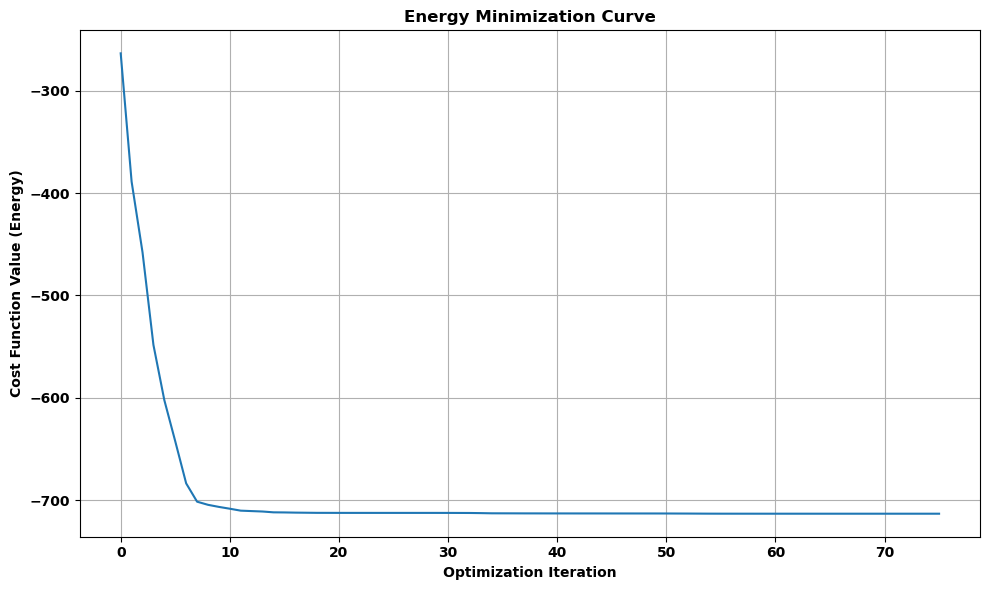

In [22]:
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

num_features = Xct1bool.shape[1]  # Get the number of features dynamically

interaction_observable = create_interaction_observable_from_histogram(joint_counts, num_features, min_ones = 2, standardize=False)
print("Interaction observable CT1 from histogram:", interaction_observable)

static_params, variable_params = create_parameter_dictionaries(ansatz_grn_ct1_co, ct1_percentages)

print("Static Parameters:", static_params)
print("Variable Parameters:", variable_params)

estimator = StatevectorEstimator()

# Initialize variable parameters
x0_interaction = np.zeros(len(variable_params))  # All zeros

# Create initial full parameter dictionary - THIS IS THE KEY CHANGE
all_params = static_params.copy()  # Start with static parameters
all_params.update(dict(zip(variable_params, x0_interaction)))  # Add variable parameters

cost_values = []
# Call minimize with args
result_interaction_bfgs = minimize(
    cost_func_wrapper,
    x0_interaction,
    args=(all_params, ansatz_grn_ct1_co, interaction_observable, estimator, variable_params), # Pass all the arguments as a tuple
    method="L-BFGS-B",
    callback=lambda xk: cost_values.append(cost_func_wrapper(xk, all_params, ansatz_grn_ct1_co, interaction_observable, estimator, variable_params))
)

print(result_interaction_bfgs)

# --- 6. Results and DataFrame ---
optimized_variable_parameters = result_interaction_bfgs.x

# Update the full parameter dictionary with optimized variable parameters
for param, value in zip(variable_params, optimized_variable_parameters):
    all_params[param] = value

import matplotlib.pyplot as plt

# Plot the cost function values
plt.figure(figsize=(10, 6))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

The counts are: {'1010': 29, '0000': 60, '1000': 126, '0110': 689, '0111': 69, '1101': 2, '1100': 2, '0001': 5, '0010': 11, '1110': 11, '0100': 8, '1111': 1, '0101': 4, '1001': 5, '1011': 2}


C:\Users\ssromerogon\AppData\Local\Temp\ipykernel_35344\3780699962.py:148: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts, title=title).show()


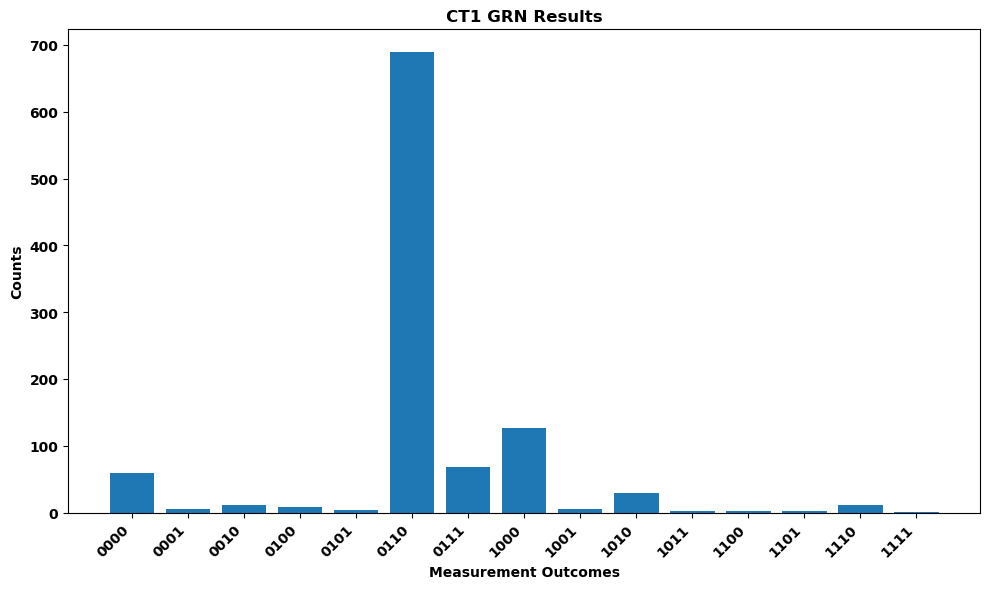

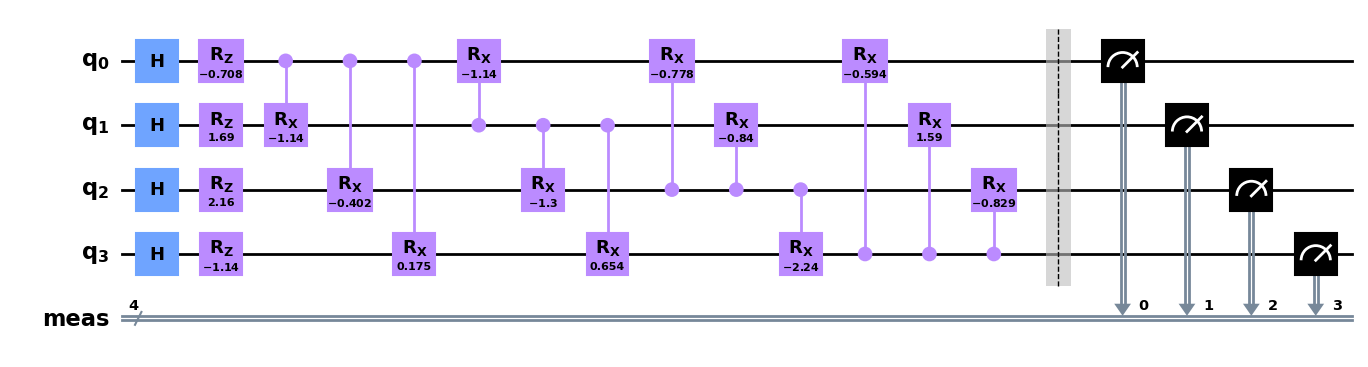

In [23]:
counts_ct1, bound_circuit = evaluate_and_plot_ansatz(ansatz_grn_ct1_co, all_params, title="CT1 GRN Results")

bound_circuit.draw(output="mpl", style="clifford", fold=40)  # Show the circuit plot

Interaction observable CT2 from histogram: SparsePauliOp(['ZZZ', 'ZII', 'IIZ', 'IZZ', 'ZIZ', 'IZI', 'ZZI'],
              coeffs=[ -57.+0.j, -305.+0.j, -191.+0.j,  -47.+0.j, -261.+0.j,  -82.+0.j,
  -63.+0.j])
Static Parameters: {Parameter(ct2_act_0): 0.1025051379419024, Parameter(ct2_act_1): -1.7639425820835741, Parameter(ct2_act_2): -0.4527310259100699}
Variable Parameters: [Parameter(ct2_grn_0_1), Parameter(ct2_grn_0_2), Parameter(ct2_grn_1_0), Parameter(ct2_grn_1_2), Parameter(ct2_grn_2_0), Parameter(ct2_grn_2_1)]
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -254.33416286240603
        x: [ 1.641e+00 -2.137e+00  2.176e+00  2.670e-01 -3.574e+00
            -1.996e+00]
      nit: 23
      jac: [-6.537e-05 -1.137e-05 -8.527e-06  1.421e-05  1.137e-05
             8.527e-06]
     nfev: 203
     njev: 29
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


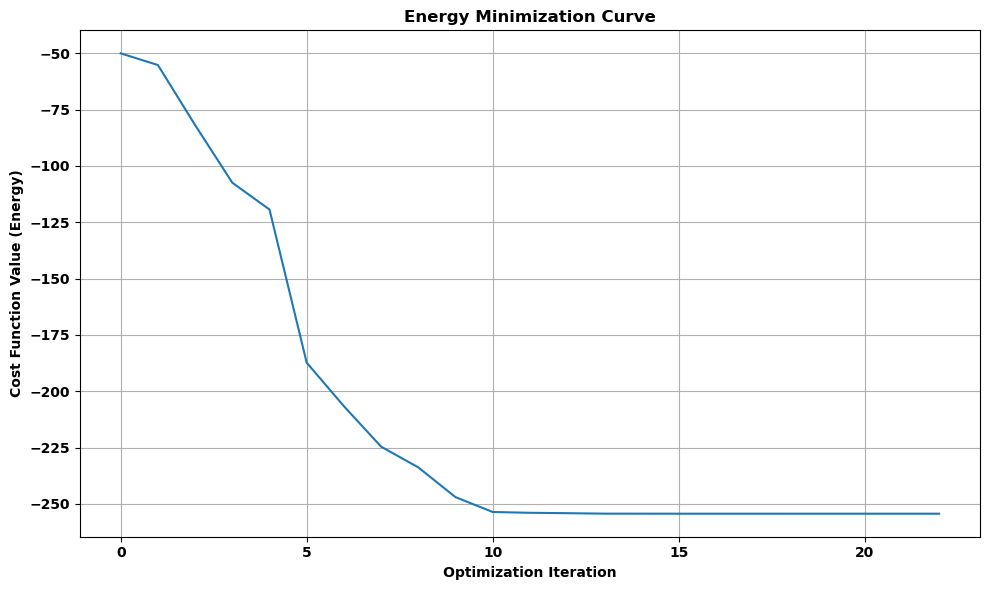

In [24]:
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

num_features2 = Xct2bool.shape[1]  # Get the number of features dynamically

interaction_observable2 = create_interaction_observable_from_histogram(joint_counts2, num_features2, min_ones = 1, standardize=False)
print("Interaction observable CT2 from histogram:", interaction_observable2)

static_params2, variable_params2 = create_parameter_dictionaries(ansatz_grn_ct2_co, ct2_percentages)

print("Static Parameters:", static_params2)
print("Variable Parameters:", variable_params2)

estimator = StatevectorEstimator()
# Initialize variable parameters
x0_interaction = np.zeros(len(variable_params2))  # All zeros

# Create initial full parameter dictionary - THIS IS THE KEY CHANGE
all_params2 = static_params2.copy()  # Start with static parameters
all_params2.update(dict(zip(variable_params2, x0_interaction)))  # Add variable parameters

cost_values = []
# Call minimize with args, using a lambda for the callback
result_interaction_bfgs = minimize(
    cost_func_wrapper,
    x0_interaction,
    args=(all_params2, ansatz_grn_ct2_co, interaction_observable2, estimator, variable_params2),
    method="L-BFGS-B",
    callback=lambda xk: cost_values.append(cost_func_wrapper(xk, all_params2, ansatz_grn_ct2_co, interaction_observable2, estimator, variable_params2))
)

print(result_interaction_bfgs)

# --- 6. Results and DataFrame ---
optimized_variable_parameters = result_interaction_bfgs.x

# Update the full parameter dictionary with optimized variable parameters
for param, value in zip(variable_params2, optimized_variable_parameters):
    all_params2[param] = value

import matplotlib.pyplot as plt

# Plot the cost function values
plt.figure(figsize=(10, 6))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

The counts are: {'011': 24, '010': 434, '101': 405, '000': 143, '110': 8, '111': 7, '001': 3}


C:\Users\ssromerogon\AppData\Local\Temp\ipykernel_35344\3780699962.py:148: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts, title=title).show()


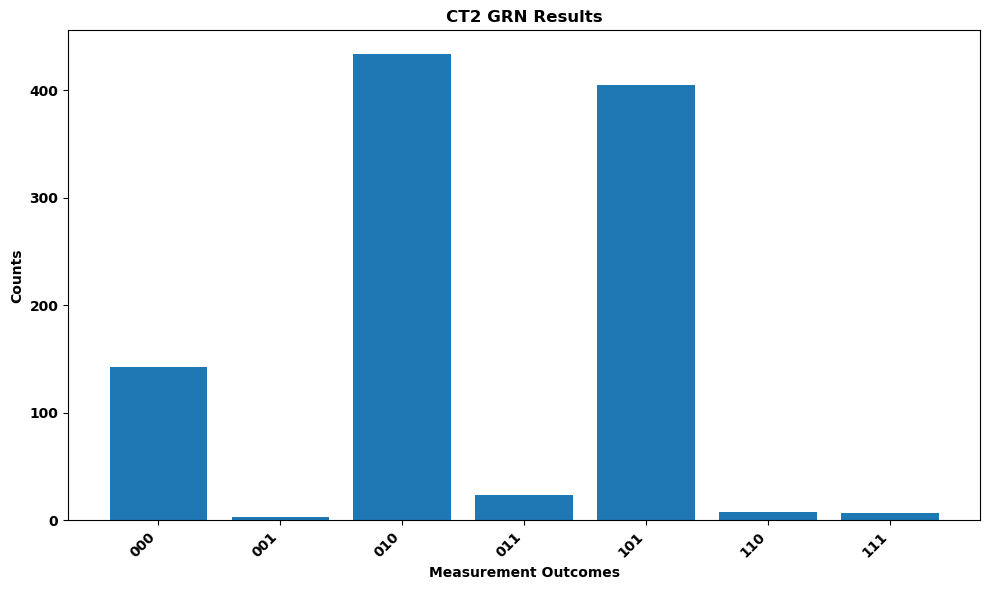

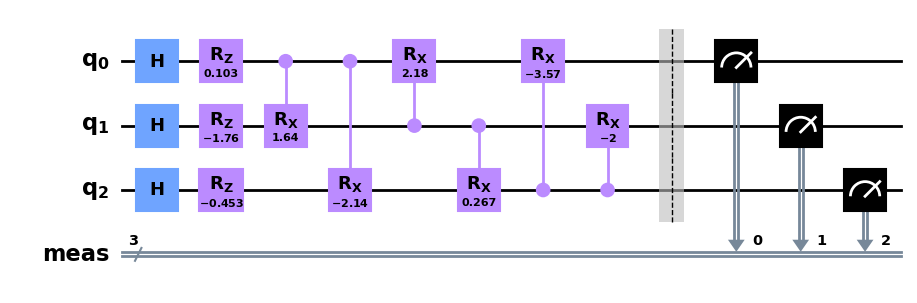

In [25]:
counts_ct2, bound_circuit2 = evaluate_and_plot_ansatz(ansatz_grn_ct2_co, all_params2, title="CT2 GRN Results")

bound_circuit2.draw(output="mpl", style="clifford", fold=40)  # Show the circuit plot